In [ ]:
library('e1071')

In [1]:
# load some libraries and helpers
library(repr)
library(MASS)
library(caret)
library(tidyverse, warn.conflicts = FALSE)
library(class)
library(scatterplot3d)
source('helpers.R')

Loading required package: lattice
Loading required package: ggplot2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ dplyr   0.7.6
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
✖ dplyr::select() masks MASS::select()


# Intro to Machine Learning

**Objectives**: To start this workshop, we are going to work with some basic machine learning algorithms. Machine learning is a rich and exciting area of computer science that is often considered a subset of the broader field of artificial intelligence. At its most basic level, machine learning seeks to build algorithms that allow systems to perform actions without explicitly being programmed. In this first notebook, we are going to: 
  
* Review applications of machine learning
* Use a supervised learning model
* Use an unsupervised learning model

## Machine Learning

Machine learning is a core component of many data-driven products. Recommendation engines, self-driving cars, credit scoring, spam filtering, product ranking, customer support, and even medical diagnoses are all examples of where machine learning is being applied. 

Machine learning is in the top five skills identified in LinkedIn profiles of current data scientists. 

<img src="https://raw.githubusercontent.com/azbones/big_data/master/images/rjmetrics-ml.png">
(source: https://rjmetrics.com/resources/reports/the-state-of-data-science/)


Amazon Web Services has a machine learning product which can be used for batch or real time analysis on their infrastructure.

* [Amazon Web Services Machine Learning](https://aws.amazon.com/machine-learning/)

Google recently open-sourced part of their machine learning libraries that are available at:

* "[Tensorflow](http://www.tensorflow.org/) is designed to facilitate research in machine learning, and to make it quick and easy to transition from research prototype to production system."

Microsoft's Azure platform now has a machine learning product that is part of their Cortana Analytics Suite which has a drag and drop interface (ML Studio) for deploying machine learning in their cloud using R and Python.

* [Azure Machine Learning](https://azure.microsoft.com/en-us/services/machine-learning/) is "a fully managed big data and advanced analytics suite that enables you to transform your data into intelligent action."


Even non-profits like Kahn Academy are using machine learning in their production systems:

* [Khan Academy Machine Learning → Measurable Learning](http://derandomized.com/post/51729670543/khan-academy-machine-learning-measurable)

If you are interested in learning more about Machine Learning, I suggest the course by Andrew Ng from Stanford which is available on Coursera:

* https://www.coursera.org/learn/machine-learning

## Supervised Learning

One way to subdivide the machine learning domain is by supervised or unsupervised learning. 

In supervised learning, a training dataset is used to build a model that is then applied to new observations to make predictions. The training dataset has both the predictor variables (often called features in ML parlance) and the "correct" answers or outcome that you are seeking to predict. In traditional statistics classes, the model features will be called independent variables and the predicted values are dependent variables.

Often after developing the model, a separate, test dataset is used to measure how well the model performs with new data.

Predictions can include:

* **Classification:** The model is used to classify observations into categorical values or classes (e.g.- for a cancer test, there might be the categories of "benign", "precancerous", and "malignant").

* **Regression:** The model is used to predict values that are continuous in nature (e.g.- measures with infinite measures like temperature).

Supervised machine learning algorithms can include:

* Decision trees
* Discriminant analysis
* Naïve Bayes classifiers
* Nearest neighbors
* Neural networks
* Support machine vectors

Today, we are going to use the Nearest Neighbor or K-Nearest Neighbor (KNN) algorithm to explore supervised learning in a classification example.

**KNN Algorithm**

KNN is one of the simplest and most used supervised learning algorithms. While it can be used for both regression and classification, we are going to use it for classification.

Simply, the algorithm uses the distance between an observation's feature vector (the values of the features that describe it) and the training dataset to determine group membership. 

The K refers to the number of neighbors you set to evaluate versus each observation. The algorithm uses distance (most often Euclidian although there are many options here) to determine the K closest neighbors and then classify the observation based on the class that results in the smallest misclassification cost. So, if you select a K of five and three of the five closest points are in group A, that observation would be classified as part of group A. You should select odd values of K to avoid any ties when calculating the lowest misclassification cost.

**Create Synthetic Dataset**

To begin, we are going to create a synthetic dataset. The <code>make_blobs</code> function allows us to create distinct groups by drawing random samples form a Gaussian distribution.

Our synthetic dataset will have 1000 samples, 5 defined centers, and 2 features.

```
data_points - A data frame carrying features variables V1 and V2, and outcome variable y
```
Run the code in the following block to generate the data.

In [2]:
# Generate a 2 dimensional synthetic dataset

data_points_2d <- make_blobs(n = 1000, centers = 5, min = -5, max = 5, var = 0.15, n_features = 2, seed = 100)

In [3]:
# Explore data_points to see what it contains

head(data_points_2d)

V1,V2,y
-1.5267217,-2.299870,Group 1
-1.7048057,-2.648602,Group 1
-1.5301776,-2.146538,Group 1
-0.7523825,-2.742897,Group 1
-2.0510576,-2.562649,Group 1
-2.4027870,-2.388462,Group 1


**Plot the Synthetic Data**

Now, we are going to plot the features as x and y coordinates and the outcome groupings by color. Remember this data is our training dataset, so we have both the predictors (x and y coordinates on our graph) and the thing we want to predict, group membership. Practically, an example of this might be features of e-mail and whether we, as experts, classified those individual messages as spam or non-spam.

Plot the data below.

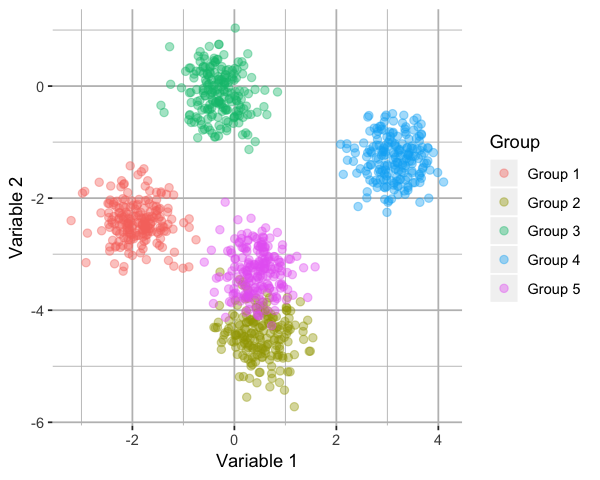

In [4]:
options(repr.plot.width=5, repr.plot.height=4)

data_points_2d %>%
    ggplot(aes(V1, V2)) +
    geom_point(aes(color = y), size = 2, alpha=.4) +
    labs(x = "Variable 1", y = "Variable 2",
         color = "Group") +
    theme(panel.background = element_rect(fill = 'white', colour = 'white'),
          panel.grid.major = element_line(color = "grey"),
          panel.grid.minor = element_line(color = "grey")) +
    guides(colour = guide_legend(override.aes = list(size=2)))

**Build the KNN Model**

Next, we are going to build our KNN classifier and fit the model to the training data.  For this initial attempt, we will use a k value of 1, so set <code>k</code> inside <code>tuneGrid</code> to 1 and run.

In [ ]:
install.packages("e1071")

In [5]:
# Fit a KNN model and assess it's accuracy
set.seed(100)
mod_knn_2d <- train(y ~ V1 + V2, data = data_points_2d, method = "knn", preProcess = c("center", "scale"),
                    tuneGrid = expand.grid(k = 1), trControl = trainControl(method = "LGOCV", number = 1, p = 0.66))
cat(paste0("Accuracy of the model is ", round(mod_knn_2d$results$Accuracy * 100, 2), "%."))

ERROR: Error: package e1071 is required


**Experiment with the Model**

Start with changing the variance parameter ```var``` of the synthetic data generator to have a larger value and re-run the model to see how the model accuracy change. Try changing the ```k``` parameter to increase the number of nearest neighbors our algorithm looks for. Remember, ```k``` should be an odd number so we can get a definitive winner from looking at the neighbors.

**Make a "Recommender System"- Predict Group Membership for a New Observation**

Now we have a classifier that can take any two-feature inputs and predict group membership. Populate the features with some example values and run the prediction in the next block.

In [6]:
# Predict group membership based values entered in predict fucntion.

obs_one_2d <- c('V1' = 0.1, 'V2' = -0.1) # These are arbitrary values for V1 and V2- try changing them and see the results
obs_two_2d <- c('V1' = 3.5, 'V2' = -1.2) # These are arbitrary values for V1 and V2- try changing them and see the results

predictions_2d <- predict(mod_knn_2d, newdata = bind_rows(obs_one_2d, obs_two_2d))

cat("An observation with features values", obs_one_2d, "is predicted to be of the class",
    as.character(predictions_2d[1]), "\n")
cat("An observation with feature values", obs_two_2d, "is predicted to be of the class",
    as.character(predictions_2d[2]))

ERROR: Error in predict(mod_knn_2d, newdata = bind_rows(obs_one_2d, obs_two_2d)): object 'mod_knn_2d' not found


**N-dimensional Features**

While our example using two features was instructive as a visualization, most machine learning problems will have many more features. Unfortunately, plotting the feature space of predictions is not possible beyond three dimensions (even three dimensional plots are difficult to use given they are rendered in two dimensions). The KNN models work exactly the same way, regardless of the number of features.

Build a synthetic dataset with three features below.

In [ ]:
# Generate a 3 dimensional synthetic dataset

data_points_3d <- make_blobs(n = 1000, centers = 4, min = -5, max = 5, var = 0.6, n_features = 3, seed = 999)

In [ ]:
head(data_points_3d)

Plot the training values with a 3D projection.

In [ ]:
# 3D plot of three features from training data
# Source: https://gist.github.com/agstudy/7908344

group_colors <- setNames(gg_color_hue(4), paste("Group", 1:4))

scatter.grid(data_points_3d[, 1:3], pch = 16, color = group_colors[data_points_3d$y], cex.symbols = 0.35,
             grid = c('xy','xz','yz'), box = FALSE, xlab = "Variable 1", ylab = "Variable 2", zlab = "Variable 3")

legend("topright", legend = names(group_colors), col = unname(group_colors), pch = 16, cex = 0.5, pt.cex = 0.9,
       bty = "n", xpd = TRUE, y.intersp = 2.5)

**Build the KNN Model for Three Features**

Next, we are going to build our KNN classifier and fit the model to the new training data. For this initial attempt, we will use a k value of 1, so set <code>k</code> inside <code>tuneGrid</code> to 1 and run.

In [ ]:
# Fit a KNN model and assess it's accuracy
set.seed(100)
mod_knn_3d <- train(y ~ V1 + V2 + V3, data = data_points_3d, method = "knn", preProcess = c("center", "scale"),
                    tuneGrid = expand.grid(k = 1), trControl = trainControl(method = "LGOCV", number = 1, p = 0.66))
cat(paste0("Accuracy of the model is ", round(mod_knn_3d$results$Accuracy * 100, 2), "%."))

**Predict Group Membership with Three Values**

Populate the observation values and predict group membership below.

In [ ]:
# Another prediction based on 3 features.

obs_one_3d <- c('V1' = 2.2, 'V2' = -2.1, 'V3' = 1.9)
obs_two_3d <- c('V1' = -2.5, 'V2' = -1, 'V3' = -3.5)
obs_three_3d <- c('V1' = 3, 'V2' = 0.0, 'V3' = 4)

predictions_3d <- predict(mod_knn_3d, newdata = bind_rows(obs_one_3d, obs_two_3d, obs_three_3d))

cat("An observation with features values", obs_one_3d, "is predicted to be of the class",
    as.character(predictions_3d[1]), "\n")
cat("An observation with features values", obs_two_3d, "is predicted to be of the class",
    as.character(predictions_3d[2]), "\n")
cat("An observation with features values", obs_three_3d, "is predicted to be of the class",
    as.character(predictions_3d[3]), "\n")

## Unsupervised Learning

As you may have guessed, unsupervised learning does not use a training set, but instead draws inferences about the data from the data itself without defined labels.

<img src="http://imgs.xkcd.com/comics/watson_medical_algorithm.png">
(source: http://xkcd.com/1619/)

The most common use case for unsupervised learning is cluster analysis. Examples of cluster analysis include:

* **Genetic Classification:** Genome sequencing dataset can be used to group individuals or organisms with similar properties.

* **Document Classification:** Documents with similar topics, based on NLP, can be grouped together. 
* **Behavioral Cohort Analysis:** Clustering users together based on their behavior.


Unsupervised machine learning algorithms can include:

* Gaussian mixture models
* Hidden Markov models
* Hierarchical clustering
* K-Means clustering

We are going to use the k-means algorithm to explore unsupervised learning.

**K-Means Algorithm**

The k-means algorithm is an iterative algorithm that starts by locating the k cluster centers in arbitrary locations within the multi-dimensional feature space. It then assigns each observation to the mean center that it is closest to using a distance calculation (usually Euclidian). It then iterates through randomly assigned cluster centers until has minimized the distance from each observation to its cluster center. This is calculated by looking at the sum of distances for all observations to the selected center over all the centers. 

Given its simplicity, k-means also has higher performance than other clustering techniques and is therefore quite popular for larger datasets.

**Create Synthetic Dataset**

We are again going to create a synthetic dataset, but we are not going to use the group membership in our model. This is the definition of unsupervised learning. While we will know apriori how many clusters our data has, this will allow us to better understand the algorithm as we evaluate different models with the data.

In [ ]:
# Generate a 2 dimensional synthetic dataset for K-Means

data_points_2d_km <- make_blobs(n = 5000, centers = 10, min = -15, max = 15, var = 2, n_features = 2, seed = 1)
data_points_2d_km$y <- NULL
head(data_points_2d_km)

**Plot the Synthetic Data**

Now we will plot the data.  Notice we are not using group membership in our dataframe or our plot. Our synthetic dataset will have some well defined groups that are clearly seen in a two dimensional plot and some clusters that are overlapping the same feature space. 

Most real datasets will be more complex in that they have many more features and less differentiation among these features, so clusters are not as likely to be seen in plots given less uniform distributions.

Run the code below to plot the data. Count the number of clusters that are clearly visible in the plot.

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

data_points_2d_km %>%
    ggplot(aes(V1, V2)) +
    geom_point(size = 1, alpha = .4, color = "steelblue") +
    labs(x = "Variable 1", y = "Variable 2") +
    theme(panel.background = element_rect(fill = 'white', colour = 'white'),
          panel.grid.major = element_line(color = "grey"),
          panel.grid.minor = element_line(color = "grey"))

**Build the K-Means Model**

We are again going to use R to build our model. Other than the data, the key input into k-means is k or the number of clusters you want to model. We will review how to evaluate different values for k after we build our initial model. Other unsupervised algorithms can derive the number of clusters on their own, but also come with more complexity.

Depending on the dataset, the number of iterations defined by the <code>init</code> parameter can also be important as k-means can be subject to local minima which will result in poor cluster results. Given k-means uses random inputs, it is often useful to run it multiple times to assure that it is consistently converging.

We will start with three clusters to see how the algorithm handles the synthetic data.

Define the number of clusters in the <code>cluster_num</code> varaiable and run the codeblock below to create the model with three centers and fit it to the data.

In [ ]:
# Fit k-means model to data.

n_clusters <- 3

mod_km <- kmeans(data_points_2d_km, centers = n_clusters, iter.max = 20, nstart = 10)

Now, plot the data using the cluster numbers that we added to the dataframe. Remember, the actual cluster membership, or ground truth in machine learning terms, is not part of our data.

In [ ]:
# Plot observations with color coding for each cluster.

options(repr.plot.width=6, repr.plot.height=5)

data_points_2d_km %>%
    dplyr::mutate(cluster = factor(paste("Cluster", mod_km$cluster))) %>%
    ggplot(aes(V1, V2)) +
    geom_point(aes(color = cluster), size = 1, alpha = .4) +
    labs(x = "Variable 1", y = "Variable 2",
         color = "Cluster") +
    theme(panel.background = element_rect(fill = 'white', colour = 'white'),
          panel.grid.major = element_line(color = "grey"),
          panel.grid.minor = element_line(color = "grey")) +
    guides(colour = guide_legend(override.aes = list(size = 2, alpha = 1)))

**Print Cluster Centers**

We can directly access the cluster center coordinates from our model by calling the <code>cluster\_centers\_</code> attribute.

Print those below.

In [ ]:
mod_km$centers

Now, let's replot the data with the color-coded cluster membership along with the cluster centers as large x's.

In [ ]:
# Now add cluster centers to same plot.

options(repr.plot.width=6, repr.plot.height=5)

data_points_2d_km %>%
    dplyr::mutate(cluster = factor(paste("Cluster", mod_km$cluster))) %>%
    ggplot(aes(V1, V2)) +
    geom_point(aes(color = cluster), size = 1, alpha = .4) +
    geom_point(data = as_tibble(mod_km$centers), shape = 4, size = 5, stroke = 1.2) +
    labs(x = "Variable 1", y = "Variable 2",
         color = "Cluster") +
    theme(panel.background = element_rect(fill = 'white', colour = 'white'),
          panel.grid.major = element_line(color = "grey"),
          panel.grid.minor = element_line(color = "grey")) +
    guides(colour = guide_legend(override.aes = list(size = 2, alpha = 1)))

**Change K**

Now, go back through the code and change K to different values and rerun the model and plots to see how the algorithm performs.

**Determining Optimal K**

Unfortunately, there is not an exact way to determine the right number of clusters given part of the value of clusters is they have some meaning that can be put to use. The most accurate number of clusters to represent all the observations would be a cluster for every observation. Or course, that approach completely loses the value of having a much smaller set of groups that can be used to generalize across many cases.

So, the challenge is having a relatively small set of clusters that have small average distances to the hypothetical mean centroid values while also having each centroid sufficiently distant from the others to provide for distinctness among clusters. Ideally, these cluster can also be understood as a segment or profile (rather than just the mathematical means) such that the clusters can aid in analysis or decision making. User behavioral cohorts, for example, might be given titles that sum up the multiple features that comprise the cluster like "casual users", "power users", etc.

**Neural Networks**

In the next part of this workshop, we will extend our basic machine learning concepts in the realm of neural networks.

## [Please continue in the next notebook page by clicking here](neural_networks_mnist_r_part1.ipynb)